In [28]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil import tz
from datetime import datetime, timedelta, date
import sqlalchemy

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf

In [2]:
local_tz = tz.gettz('Asia/Jakarta')

end_date_str = '2022-12-31 23:59:59'
end_datetime = datetime.fromisoformat(end_date_str)

end_datetime_utc = end_datetime - timedelta(hours=7)
df = pd.read_sql(query, con = engine)

In [3]:
### CLEAN DATA
df['name'] = df['name'].str.lower().str.strip()
df = df[df['name'].str.len() >= 3]
df = df[~df['name'].str.contains("test")]
TEST_SUPPLIERS = ["61c3718e299b1a9823d96889", "61d22dbfbf6028f247dee589", "5e158927d2c62c61d3f0da87", "615fe60d7bf24978fb5f9c1f"]
df = df[~df['num_supplier'].isin(TEST_SUPPLIERS)]
df['first_placed_at'] = df['first_placed_at'] + pd.DateOffset(hours=7)
df['first_placed_at'] = df['first_placed_at'].dt.normalize()
df['last_placed_at'] = df['last_placed_at'] + pd.DateOffset(hours=7)
df['last_placed_at'] = df['last_placed_at'].dt.normalize()
df['duration'] = pd.to_datetime(df['last_placed_at']) - pd.to_datetime(df['first_placed_at'])
df['duration'] = df['duration'].dt.days+1


#remove null amount
df = df.dropna(subset=['total_amount'])
df = df.loc[(df['price'] > 0) & (~df['price'].isna())]
df.head(10)

,id,num_order,num_supplier,merchant_id,first_placed_at,last_placed_at,num_sku,sum_qty,price,total_amount,name,duration
0,2766,30,1,5e5cb7dffe16a51d81cb7b6d,2020-07-06,2022-04-11,382,488888.0,1825000.0,1.716281e+09,magnum blue,645
1,4601,88,5,5ea27d33b9a6b42df34f3795,2020-08-04,2022-08-10,114,166120.0,226000.0,4.130098e+08,camel yellow 20 slp,737
2,8011,67,1,5d92c650f0d8b3eef15d235c,2020-09-17,2022-12-29,274,3154684.0,3340000.0,2.986518e+09,gg international 12 bal (10slp),834
3,7968,2,1,5f0c165cb9a6b456f533c997,2020-09-17,2021-05-22,62,313.0,1.0,1.868395e+08,kapal api mix 25gr k10,248
4,9668,1,1,5f72f6c37db84d00016f45ce,2020-09-29,2020-09-29,1,2.0,14500.0,2.900000e+04,racik ikan goreng 10x20g,1
5,9653,1,1,5f7582917db84d00016f4677,2020-10-01,2020-10-01,1,20.0,42000.0,8.400000e+05,aqua 600ml,1
6,9747,1,1,5f05799eb9a6b47c762cafe4,2020-10-04,2020-10-04,4,8.0,14500.0,1.160000e+05,racik ikan goreng 10x20g,1
7,9781,1,1,5f72f6c37db84d00016f45d0,2020-10-04,2020-10-04,1,1.0,14500.0,1.450000e+04,racik ayam goreng 10x26g,1
8,10263,6,2,5f72f6c37db84d00016f45d5,2020-10-05,2022-06-23,26,65.0,14500.0,6.025100e+06,racik tempe goreng 10x20g,627
9,11167,1,1,5f6978397db84d00016f435a,2020-10-20,2020-10-20,1,200.0,1700.0,3.400000e+05,vit gelas,1


In [4]:
#Merchant Outlier create dataframe column
mdf = pd.DataFrame()
mdf['A'] = df['num_supplier']/df['num_sku']
mdf['B'] = df['num_sku']
mdf['C'] = df['num_order']
mdf['D'] = df['total_amount']/df['num_supplier']
mdf['E'] = df['sum_qty']/(df['num_supplier']*df['duration'])
mdf['F'] = df['num_sku']/df['duration']

mdf['base'] = df['num_order']/df['duration'] 

#normalize the data
x = mdf.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
mdf = pd.DataFrame(x_scaled, columns = [chr(i) for i in range(65,71)]+['base'])

mdf.head(10)

,A,B,C,D,E,F,base
0,0.001905,0.149764,0.001215,7.340066e-05,3.787709e-06,0.003615,0.000362
1,0.043177,0.044418,0.003645,3.532660e-06,2.252458e-07,0.000930,0.000967
2,0.002938,0.107311,0.002765,1.277252e-04,1.890251e-05,0.001997,0.000643
3,0.015426,0.023978,0.000042,7.990617e-06,6.276817e-09,0.001515,0.000043
4,1.000000,0.000000,0.000000,1.240208e-09,9.964298e-09,0.006116,0.008280
5,1.000000,0.000000,0.000000,3.592447e-08,9.991466e-08,0.006116,0.008280
6,0.249464,0.001179,0.000000,4.960961e-09,3.994775e-08,0.024521,0.008280
7,1.000000,0.000000,0.000000,6.200827e-10,4.967056e-09,0.006116,0.008280
8,0.076264,0.009827,0.000209,1.288385e-07,2.288412e-10,0.000236,0.000055
9,1.000000,0.000000,0.000000,1.454083e-08,9.994183e-07,0.006116,0.008280


C:\Users\ROG\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    44850
-1       90
Name: anomaly_iso_A, dtype: int64


C:\Users\ROG\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    44850
-1       90
Name: anomaly_iso_B, dtype: int64


C:\Users\ROG\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    44850
-1       90
Name: anomaly_iso_C, dtype: int64


C:\Users\ROG\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    44850
-1       90
Name: anomaly_iso_D, dtype: int64


C:\Users\ROG\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    44852
-1       88
Name: anomaly_iso_E, dtype: int64


C:\Users\ROG\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    44852
-1       88
Name: anomaly_iso_F, dtype: int64


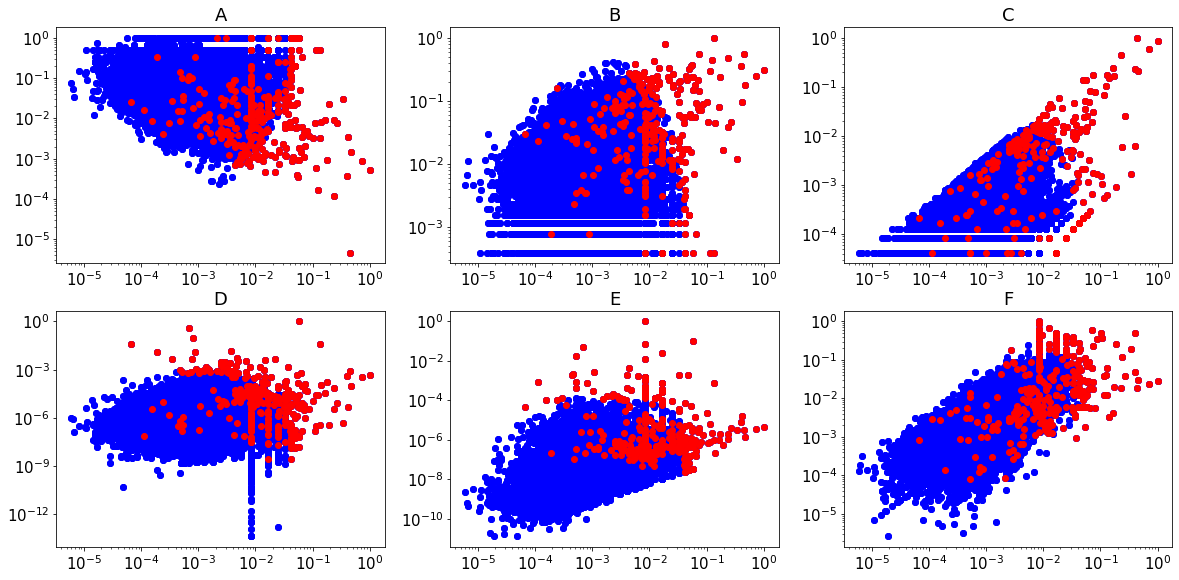

In [11]:
#isolation forest 

for i in range(65,71):
    obj = pd.concat([mdf[chr(i)],mdf['base']], axis =1)
    clf_iso=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.002), \
                            max_features=1.0, bootstrap=True, n_jobs=-1, random_state=42, verbose=0)
    clf_iso.fit(obj)
    pred = clf_iso.predict(obj)
    mdf['anomaly_iso_'+chr(i)]=pred
    print(mdf['anomaly_iso_'+chr(i)].value_counts())
    isoforest_df = mdf.loc[mdf['anomaly_iso_'+chr(i)]==-1]

    #plotting the outliers to the initial scatter plot on different metrics
    plt.subplot(4,3,i-64)
    plt.title(chr(i))
    plt.scatter(mdf['base'],mdf[chr(i)], c = 'blue')
    plt.scatter(isoforest_df['base'], isoforest_df[chr(i)], c='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.rcParams['figure.figsize'] = [20,20]
    plt.rcParams['font.size'] = 15
    
mdf['accumulation_iso'] = (mdf['anomaly_iso_'+chr(65)]+1)/2
for i in range(66,71):
    mdf['accumulation_iso'] *= (mdf['anomaly_iso_'+chr(i)]+1)/2
    
mdf['accumulation_iso'] = (mdf['accumulation_iso'])*2-1
    
isoforest_df = mdf.loc[mdf['accumulation_iso']==-1]
    
#plotting the outliers to the initial scatter plot on different metrics
for i in range(65,71):
    plt.subplot(4,3,i-64)
    plt.title(chr(i))
    plt.scatter(mdf['base'],mdf[chr(i)], c='blue')
    plt.scatter(isoforest_df['base'], isoforest_df[chr(i)], c='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.rcParams['figure.figsize'] = [20,20]
    plt.rcParams['font.size'] = 15

 1    44822
-1      118
Name: anomaly_lof_A, dtype: int64
 1    44805
-1      135
Name: anomaly_lof_B, dtype: int64
 1    44815
-1      125
Name: anomaly_lof_C, dtype: int64
 1    44805
-1      135
Name: anomaly_lof_D, dtype: int64
 1    44805
-1      135
Name: anomaly_lof_E, dtype: int64
 1    44810
-1      130
Name: anomaly_lof_F, dtype: int64


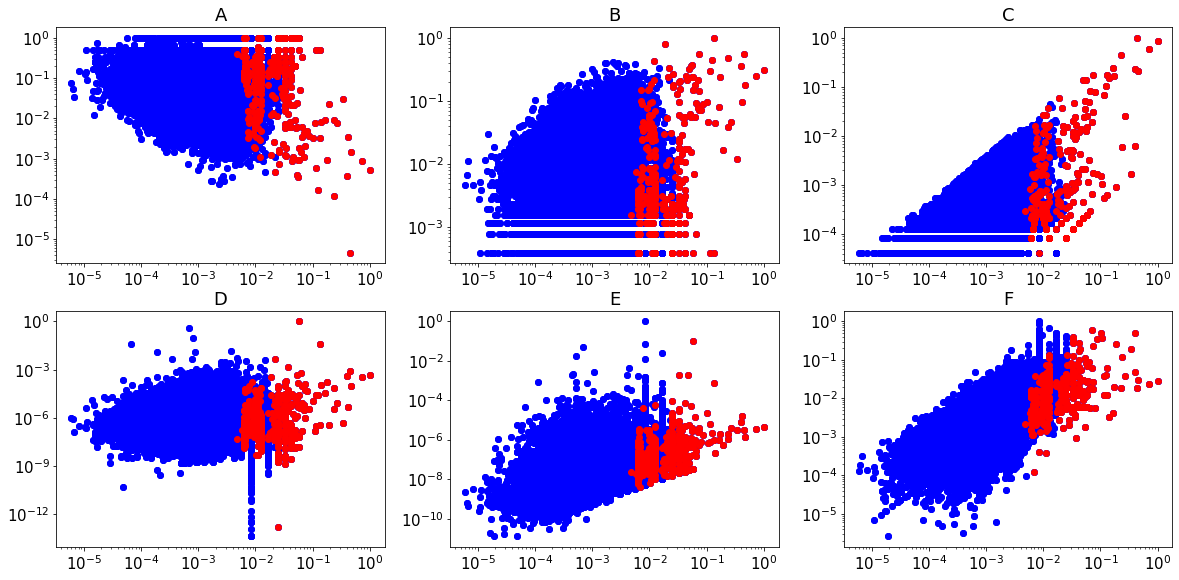

In [6]:
#local outlier factor
neighbors = [450,250,600,450,500,1100]    
    
for i in range(65,71):
    obj = pd.concat([mdf[chr(i)],mdf['base']], axis =1)
    clf_lof = LocalOutlierFactor(n_neighbors=neighbors[i-65], contamination=0.003)
    pred = clf_lof.fit_predict(obj)
    mdf['anomaly_lof_'+chr(i)]=pred
    print(mdf['anomaly_lof_'+chr(i)].value_counts())
    localfactor_df = mdf.loc[mdf['anomaly_lof_'+chr(i)]==-1]

    #plotting the outliers to the initial scatter plot on different metrics
    plt.subplot(4,3,i-64)
    plt.title(chr(i))
    plt.scatter(mdf['base'],mdf[chr(i)], c = 'blue')
    plt.scatter(localfactor_df['base'], localfactor_df[chr(i)], c='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.rcParams['figure.figsize'] = [20,20]
    plt.rcParams['font.size'] = 15
    
mdf['accumulation_lof'] = (mdf['anomaly_lof_'+chr(65)]+1)/2
for i in range(66,71):
    mdf['accumulation_lof'] *= (mdf['anomaly_lof_'+chr(i)]+1)/2
    
mdf['accumulation_lof'] = (mdf['accumulation_lof'])*2-1
    
localfactor_df= mdf.loc[mdf['accumulation_lof']==-1]
    
#plotting the outliers to the initial scatter plot on different metrics
for i in range(65,71):
    plt.subplot(4,3,i-64)
    plt.title(chr(i))
    plt.scatter(mdf['base'],mdf[chr(i)], c='blue')
    plt.scatter(localfactor_df['base'], localfactor_df[chr(i)], c='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.rcParams['figure.figsize'] = [20,20]
    plt.rcParams['font.size'] = 15

 1    44884
-1       56
Name: anomaly_svm_A, dtype: int64
 1    44882
-1       58
Name: anomaly_svm_B, dtype: int64
 1    44881
-1       59
Name: anomaly_svm_C, dtype: int64
 1    44881
-1       59
Name: anomaly_svm_D, dtype: int64
 1    44881
-1       59
Name: anomaly_svm_E, dtype: int64
 1    44883
-1       57
Name: anomaly_svm_F, dtype: int64


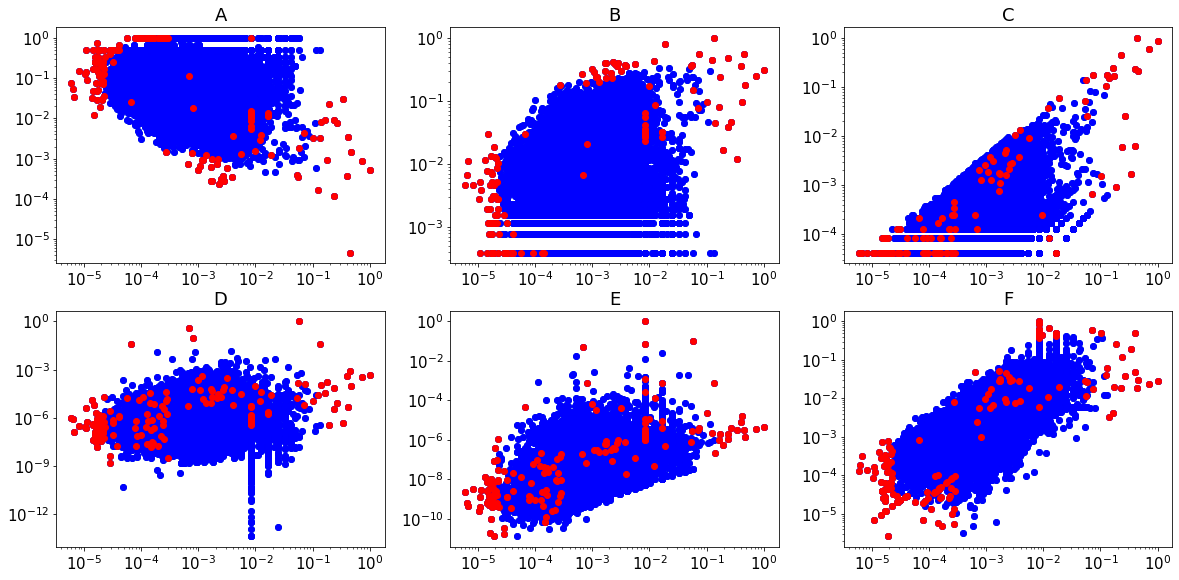

In [7]:
#outlier detection with SVM clustering
    
for i in range(65,71):
    obj = pd.concat([mdf[chr(i)],mdf['base']], axis =1)
    model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.0013)
    model.fit(obj)
    pred = model.predict(obj)
    mdf['anomaly_svm_'+chr(i)]=pred
    print(mdf['anomaly_svm_'+chr(i)].value_counts())
    svm_df = mdf.loc[mdf['anomaly_svm_'+chr(i)]==-1]

    #plotting the outliers to the initial scatter plot on different metrics
    plt.subplot(4,3,i-64)
    plt.title(chr(i))
    plt.scatter(mdf['base'],mdf[chr(i)])
    plt.scatter(svm_df['base'], svm_df[chr(i)], c='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.rcParams['figure.figsize'] = [20,20]
    plt.rcParams['font.size'] = 15
    
mdf['accumulation_svm'] = (mdf['anomaly_svm_'+chr(65)]+1)/2
for i in range(66,71):
    mdf['accumulation_svm'] *= (mdf['anomaly_svm_'+chr(i)]+1)/2
    
mdf['accumulation_svm'] = (mdf['accumulation_svm'])*2-1
    
svm_df = mdf.loc[mdf['accumulation_svm']==-1]
    
#plotting the outliers to the initial scatter plot on different metrics
for i in range(65,71):
    plt.subplot(4,3,i-64)
    plt.title(chr(i))
    plt.scatter(mdf['base'],mdf[chr(i)], c='blue')
    plt.scatter(svm_df['base'], svm_df[chr(i)], c='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.rcParams['figure.figsize'] = [20,20]
    plt.rcParams['font.size'] = 15

C:\Users\ROG\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    44917
-1       23
Name: first_output, dtype: int64


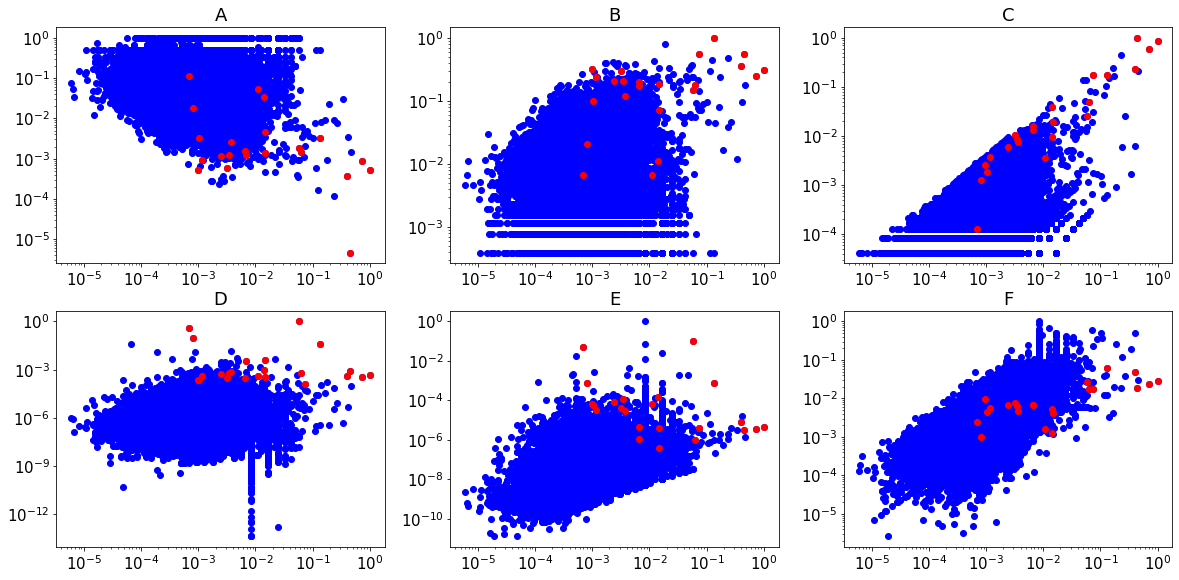

In [14]:

obj = mdf.iloc[:, list(range(0,5))]
clf_iso=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.0005), \
                        max_features=1.0, bootstrap=True, n_jobs=-1, random_state=42, verbose=0)
clf_iso.fit(obj)
pred = clf_iso.predict(obj)
mdf['first_output']=pred
print(mdf['first_output'].value_counts())
first_output = mdf.loc[mdf['first_output']==-1]

for i in range(65,71):
    #plotting the outliers to the initial scatter plot on different metrics
    plt.subplot(4,3,i-64)
    plt.title(chr(i))
    plt.scatter(mdf['base'],mdf[chr(i)], c = 'blue')
    plt.scatter(first_output['base'], first_output[chr(i)], c='red')
    plt.yscale('log')
    plt.xscale('log')
    plt.rcParams['figure.figsize'] = [20,20]
    plt.rcParams['font.size'] = 15

In [27]:
# Define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(20,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Generate random training data and labels
train_data = mdf.iloc[:35000, list(range(7,27))]
train_labels = mdf['first_output'].loc[:34999]

# Train the model on the training data
model.fit(train_data, train_labels, epochs=50, batch_size=32)

#MSE performance
prediction = model.predict(mdf.iloc[35000:, list(range(7,27))])
actual = list(mdf['first_output'].loc[35000:])

mse = tf.reduce_mean(tf.square(prediction - actual))
print(mse)

Epoch 1/50
1094/1094 [==============================] - 2s 1ms/step - loss: 0.0043
Epoch 2/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0016
Epoch 3/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0018
Epoch 4/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 5/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 6/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 7/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0014
Epoch 8/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0015
Epoch 9/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0014
Epoch 10/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0013
Epoch 11/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0013
Epoch 12/50
1094/1094 [==============================] - 1s 1ms/step - loss: 0.0014
E